In [1]:
import torch
import pandas as pd
from torch.utils.data import DataLoader
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from torch import nn, optim
from dataset import CXRMulitmodalDataset
from model import CheXagentSigLIPBinary
from transformers import AutoModel, AutoProcessor, AutoConfig

/home/jupyter-nafisha/.local/lib/python3.12/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [2]:
MODEL_NAME = "StanfordAIMI/XraySigLIP__vit-l-16-siglip-384__webli"
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
dtype = torch.float32

In [3]:
config = AutoConfig.from_pretrained(
    MODEL_NAME,
    trust_remote_code=True
)
vision_full = AutoModel.from_pretrained(
    MODEL_NAME,
    config=config,
    trust_remote_code=True
).to(device, dtype)
vision_encoder = vision_full.vision_model
del vision_full

In [4]:
checkpoint_path= '/home/jupyter-nafisha/chexAgent-Normal-Abnormal/main/best_model.pth'
model = CheXagentSigLIPBinary(vision_encoder= vision_encoder)
ckpt = torch.load(checkpoint_path, map_location="cpu", weights_only= False)
model.load_state_dict(ckpt)
model.to(device)
model.eval()

CheXagentSigLIPBinary(
  (vision_encoder): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(1024, 1024)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-23): 24 x SiglipEncoderLayer(
          (self_attn): SiglipAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): GELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096, bias=True)
            (fc2): Linear(in_features=4096, out_fe

In [13]:
# Total parameters
total_params = sum(p.numel() for p in model.parameters())

# Trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Total parameters: 317,008,417
Trainable parameters: 317,008,417


In [5]:
test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/test.csv'
img_dir = '/home/common/data_v3'

# padchest
# test_csv = '/home/jupyter-nafisha/X-ray-covariates/CSVs/PADCHEST_selected_with_reports.csv'
# img_dir = '/home/jupyter-nafisha/X-ray-covariates/padchest_normalized'

In [6]:
# data = pd.read_csv(test_csv)
# len(data)

In [7]:
test_dataset = CXRMulitmodalDataset(test_csv, img_dir, transform=None)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False, num_workers=8)

In [8]:
len(test_dataset)/4

1790.5

In [9]:
true_labels = test_dataset.df["label"].map({"Normal": 0, "Abnormal": 1}).tolist()
image_names = test_dataset.df["image_id"].tolist()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


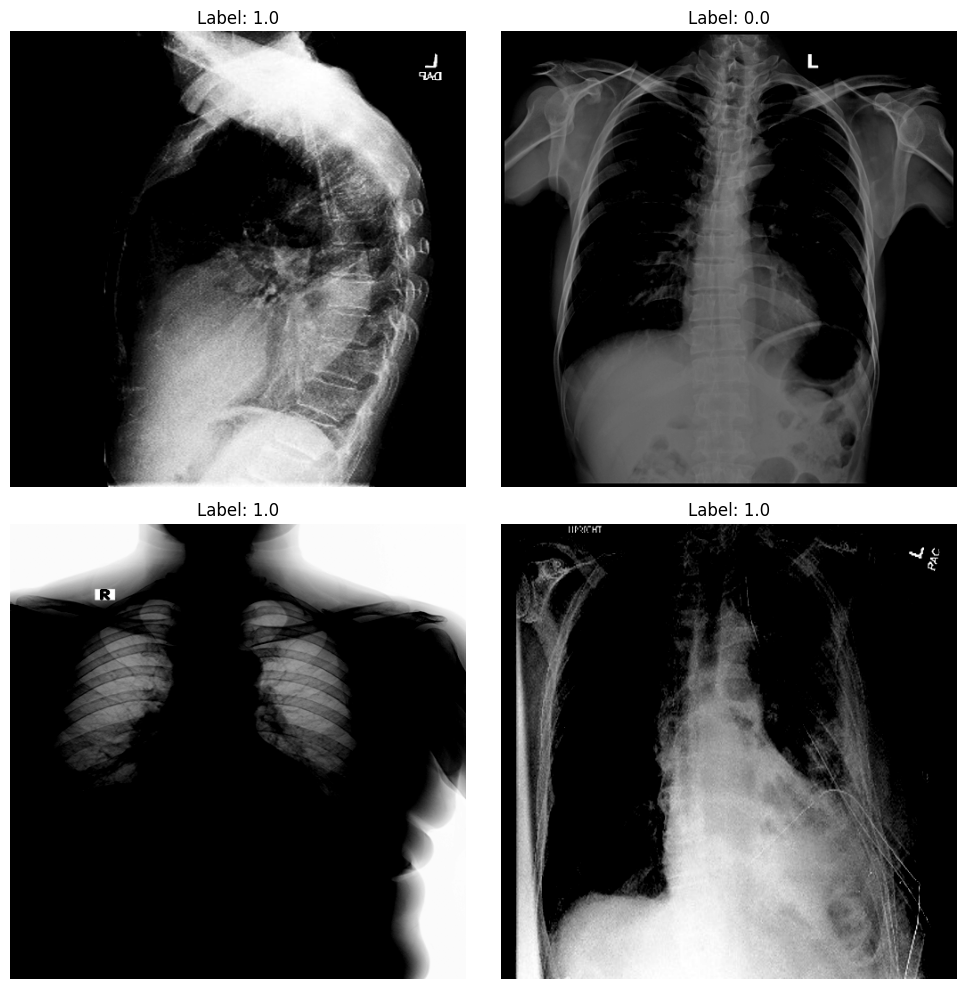

In [12]:
import matplotlib.pyplot as plt
import torch

# Get one batch
for images, view, sex, label in test_loader:
    break  # only take the first batch

# If images are normalized, unnormalize them (optional but common)
def unnormalize(img):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
    return img * std + mean

# images = unnormalize(images)

# Plot 16 images in a 4x4 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()

for i in range(4):
    img = images[i].permute(1, 2, 0)  # C,H,W → H,W,C
    axes[i].imshow(img)
    axes[i].axis("off")
    axes[i].set_title(f"Label: {label[i].item()}")

plt.tight_layout()
plt.show()

In [15]:
predictions = []
count = 0
with torch.no_grad():
    for images, view, sex, label in test_loader:  
        images = images.to(device)
        view = view.to(device)
        sex = sex.to(device)
        label = label.to(device)

        logits = model(images, view, sex)             # shape: (B, 1)
        probs = torch.sigmoid(logits).squeeze(1)      # shape: (B,)

        preds = (probs >= 0.5).long()      # thresholding for binary prediction

        predictions.extend(preds.cpu().numpy().tolist())

        if count%100==0:
            print("step:- ", count)
        count+=1

step:-  0
step:-  100
step:-  200
step:-  300
step:-  400
step:-  500
step:-  600
step:-  700
step:-  800
step:-  900
step:-  1000
step:-  1100
step:-  1200
step:-  1300
step:-  1400
step:-  1500
step:-  1600
step:-  1700


In [16]:
acc = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)
cm = confusion_matrix(true_labels, predictions)

tn, fp, fn, tp = cm.ravel()
# Specificity
specificity = tn / (tn + fp)

In [17]:
print("\n==== Evaluation Metrics ====")
print(f"Accuracy     :  {acc:.4f}")
print(f"Precision    :  {precision:.4f}")
print(f"Recall       :  {recall:.4f}")
print(f"Specificity  :  {specificity:.4f}")
print(f"F1 Score     :  {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)


==== Evaluation Metrics ====
Accuracy     :  0.8165
Precision    :  0.8318
Recall       :  0.8070
Specificity  :  0.8266
F1 Score     :  0.8193

Confusion Matrix:
[[2870  602]
 [ 712 2978]]


In [18]:
df = pd.DataFrame({
    "image_name": image_names,
    "true_label": true_labels,
    "predicted_label": predictions
})

df.to_csv("test_predictions_orig_test.csv", index=False)

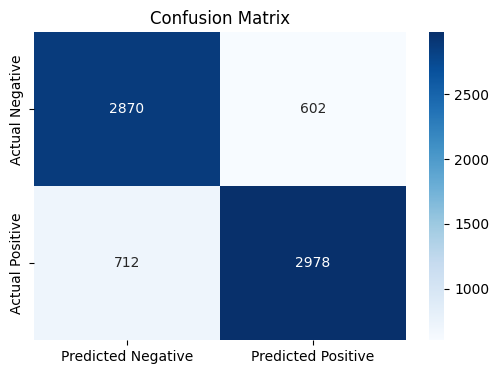

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create confusion matrix
cm = np.array([[tn, fp],
               [fn, tp]])

# Plot
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Predicted Negative", "Predicted Positive"],
            yticklabels=["Actual Negative", "Actual Positive"])
plt.title("Confusion Matrix")
plt.show()